# Imports

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
#xb = np.load('pred/feats_train_pg'+str(pg)+'.npy')
#yb = np.load('pred/targs_cl_train_pg'+str(pg)+'.npy')
#xq = np.load('pred/feats_valid_pg'+str(pg)+'.npy')
#yq = np.load('pred/targs_cl_valid_pg'+str(pg)+'.npy')

In [4]:
cts = ['HEPG2', 'HUVEC', 'RPE', 'U2OS']

In [5]:
xb = []
yb = []
#xq = []
# yq = []

In [6]:
# Everything except ct 'U2OS'
for pg in range(4):
    for ct in cts:
        print(' === ', pg ,' === ', ct , ' === ')
        if ct == 'U2OS': continue
        xb_tmp = np.load('pred/feats_train_pg'+str(pg)+ct+'.npy')
        yb_tmp = np.load('pred/targs_cl_train_pg'+str(pg)+ct+'.npy')
        print(xb_tmp.shape, yb_tmp.shape)
        if np.isnan(xb_tmp).max():
            print('Caution: nan !')
            #print(xb_tmp)
        xb.append(xb_tmp)
        yb.append(yb_tmp)
        #xq = np.load('pred/feats_valid_pg'+str(pg)+'.npy')
        #yq = np.load('pred/targs_cl_valid_pg'+str(pg)+'.npy')

 ===  0  ===  HEPG2  === 
(3872, 512) (3872,)
 ===  0  ===  HUVEC  === 
(8800, 512) (8800,)
 ===  0  ===  RPE  === 
(3872, 512) (3872,)
 ===  0  ===  U2OS  === 
 ===  1  ===  HEPG2  === 
(3872, 512) (3872,)
 ===  1  ===  HUVEC  === 
(8800, 512) (8800,)
 ===  1  ===  RPE  === 
(3872, 512) (3872,)
 ===  1  ===  U2OS  === 
 ===  2  ===  HEPG2  === 
(3872, 512) (3872,)
 ===  2  ===  HUVEC  === 
(8800, 512) (8800,)
 ===  2  ===  RPE  === 
(3872, 512) (3872,)
 ===  2  ===  U2OS  === 
 ===  3  ===  HEPG2  === 
(3872, 512) (3872,)
 ===  3  ===  HUVEC  === 
(8800, 512) (8800,)
 ===  3  ===  RPE  === 
(3872, 512) (3872,)
 ===  3  ===  U2OS  === 


In [7]:
# U2OS
ct = 'U2OS'
xb_tmp = np.load('pred/feats_train_pg0123'+ct+'.npy')
yb_tmp = np.load('pred/targs_cl_train_pg0123'+ct+'.npy')
print(xb_tmp.shape, yb_tmp.shape)
if np.isnan(xb_tmp).max():
    print('Caution: nan !')
    #print(xb_tmp)
    xb.append(xb_tmp)
    yb.append(yb_tmp)

(6600, 512) (6600,)


In [8]:
xb = np.concatenate(xb)
yb = np.concatenate(yb)
#xq = np.concatenate(xq)
#yq = np.concatenate(yq)

In [9]:
xb.shape # nb-by-d

(66176, 512)

In [10]:
#xq.shape # nq-by-d (query vectors)

In [11]:
yb.shape

(66176,)

In [12]:
#yq.shape

In [13]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 1028)

In [14]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [15]:
xb.max()

247.30565

In [16]:
faiss.normalize_L2(xb)

In [17]:
xb.max()

0.20000212

In [18]:
index.train(xb)

In [19]:
index.add_with_ids(xb, yb)

In [20]:
print(index.is_trained)
print(index.ntotal)

True
66176


## Train dataset

In [21]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[552 552 552 552 552]
 [361 361 361 361 361]
 [950 950 950 950 950]
 [436 436 436 436 436]
 [ 46 831 831 831  -1]]
[[552]
 [361]
 [950]
 [436]
 [ 46]]
[[ 9.9999970e-01  9.9023855e-01  9.8801106e-01  9.8745203e-01
   9.8697209e-01]
 [ 1.0000000e+00  9.9879420e-01  9.9849856e-01  9.9686813e-01
   9.9664640e-01]
 [ 1.0000001e+00  9.9880356e-01  9.9866611e-01  9.9842429e-01
   9.9838376e-01]
 [ 9.9999994e-01  9.9663657e-01  9.9648339e-01  9.9510336e-01
   9.9476957e-01]
 [ 1.0000000e+00  6.5777606e-01  5.3769386e-01  4.6676964e-01
  -3.4028235e+38]]


In [22]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [23]:
I_train[:,0].shape, yb.shape

((66176,), (66176,))

In [24]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [25]:
I_train[:10,0], yb[:10]

(array([552, 361, 950, 436,  46, 379, 268, 559,  40, 853]),
 array([552, 361, 950, 436,  46, 379, 268, 559,  40, 853]))

In [26]:
I_train[-10:,0], yb[-10:]

(array([ 316,  240,  526,  635,  110, 1072,  635,  634,  403,   67]),
 array([ 316,  240,  526,  635,  110, 1072,  635,  634,  403,   67]))

### Train confusion matrix

In [22]:
#cm = confusion_matrix(I_train[:,0], yb)

In [23]:
#fig, ax = plt.subplots(figsize=(15,15))
#ax.matshow(cm, cmap='hot')

## Valid dataset

In [24]:
xq.max()

175.12431

In [25]:
faiss.normalize_L2(xq)

In [26]:
xq.max()

0.18379912

In [27]:
D_valid, I_valid = index.search(xq, k) # actual search

In [28]:
xq.shape, yq.shape

((3872, 512), (3872,))

In [29]:
I_valid.shape, D_valid.shape

((3872, 5), (3872, 5))

In [30]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[523 523 523 523 523]
 [798 798 798 798 798]
 [503 503 503 503 503]
 [505 505 505 505 505]
 [ 77 577  77 577  77]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.8896632  0.88688123 0.8868655  0.8808239  0.8804276 ]
 [0.7865324  0.77226573 0.76530886 0.7605244  0.7502717 ]
 [0.93739724 0.9361016  0.9245063  0.91801465 0.9136205 ]
 [0.8096291  0.80561084 0.8040674  0.8038868  0.80100644]
 [0.73833525 0.73712873 0.73280233 0.72592235 0.7237808 ]]


In [31]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[ 764  764  764  764  764]
 [1065 1065 1065 1065 1065]
 [ 301  301  301  301  301]
 [ 757  757  757  757  757]
 [ 831  831  831  831  831]]
[[ 764]
 [1065]
 [ 301]
 [ 757]
 [ 831]]
[[0.9985708  0.9976351  0.9973368  0.99691904 0.99681044]
 [0.72257435 0.7149862  0.71417344 0.706567   0.70287037]
 [0.9468025  0.9416362  0.9412949  0.94006944 0.9388693 ]
 [0.92361426 0.9224558  0.9221511  0.9208758  0.9195591 ]
 [0.97474384 0.971219   0.96412575 0.9612801  0.95688653]]


In [32]:
np.save('pred/preds_valid_pg'+str(pg)+'.npy', I_valid)

### Valid accuracy

In [33]:
I_valid[:,0]

array([523, 798, 503, ..., 301, 757, 831])

In [34]:
yq

array([352, 361, 503, ..., 301, 757, 831])

In [35]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

2492

In [36]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.643595041322314

In [37]:
valid_correct = np.equal(I_valid[:,0], yq)

In [38]:
valid_correct

array([False, False,  True, ...,  True,  True,  True])

In [39]:
np.save('pred/preds_valid_correct_pg'+str(pg)+'.npy', valid_correct)

### Valid confusion matrix

In [40]:
cm = confusion_matrix(I_valid[:,0], yq)

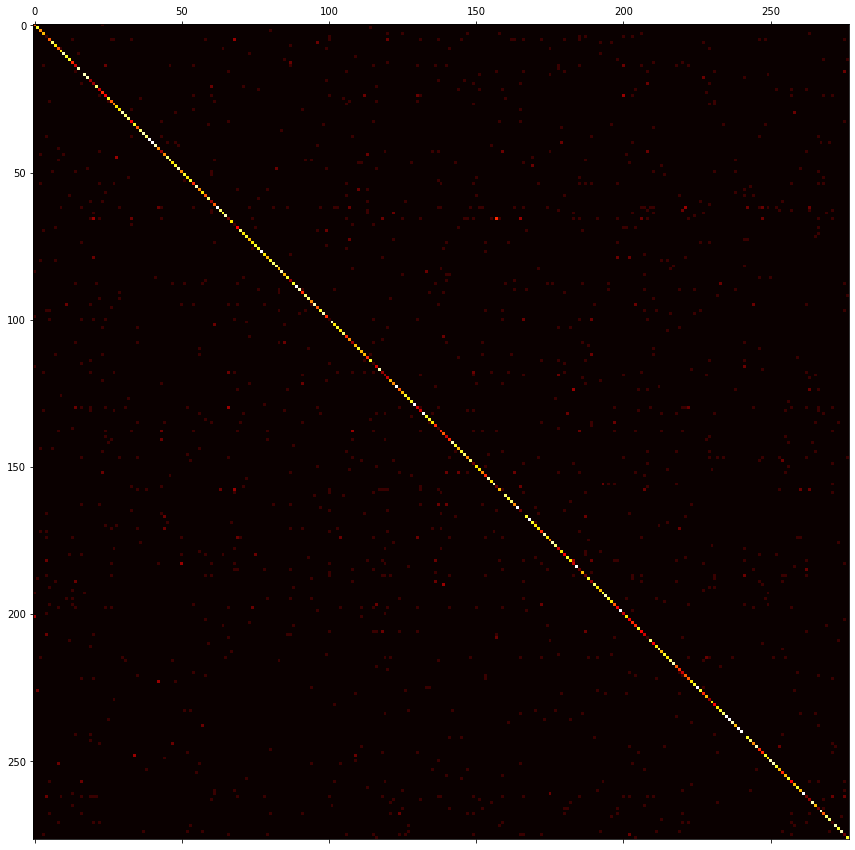

In [41]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

9690

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

5786

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.6261307831481003

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [27]:
#xq_test = np.load('pred/feats_test_pg'+str(pg)+'.npy')

In [60]:
xq_test = []

In [61]:
# Everything except ct 'U2OS'
for pg in range(4):
    for ct in cts:
        print(' === ', pg ,' === ', ct , ' === ')
        if ct == 'U2OS': continue
        xq_tmp = np.load('pred/feats_test_pg'+str(pg)+ct+'.npy')
        print(xq_tmp.shape)
        if np.isnan(xq_tmp).max():
            print('Caution: nan !')
        xq_test.append(xq_tmp)

 ===  0  ===  HEPG2  === 
(2216, 512)
 ===  0  ===  HUVEC  === 
(4428, 512)
 ===  0  ===  RPE  === 
(2210, 512)
 ===  0  ===  U2OS  === 
 ===  1  ===  HEPG2  === 
(2214, 512)
 ===  1  ===  HUVEC  === 
(4420, 512)
 ===  1  ===  RPE  === 
(2208, 512)
 ===  1  ===  U2OS  === 
 ===  2  ===  HEPG2  === 
(2214, 512)
 ===  2  ===  HUVEC  === 
(4418, 512)
 ===  2  ===  RPE  === 
(2212, 512)
 ===  2  ===  U2OS  === 
 ===  3  ===  HEPG2  === 
(2214, 512)
 ===  3  ===  HUVEC  === 
(4426, 512)
 ===  3  ===  RPE  === 
(2204, 512)
 ===  3  ===  U2OS  === 


In [62]:
len(xq_test)

12

In [63]:
np.concatenate(xq_test).shape

(35384, 512)

In [64]:
# U2OS
ct = 'U2OS'
xq_tmp = np.load('pred/feats_test_pg0123'+ct+'.npy')
print(xq_tmp.shape)
if np.isnan(xq_tmp).max():
    print('Caution: nan !')
xq_test.append(xq_tmp)

(4410, 512)


In [65]:
xq_test = np.concatenate(xq_test)

In [66]:
xq_test.shape

(39794, 512)

In [67]:
xq_test.max()

229.40651

In [68]:
faiss.normalize_L2(xq_test)

In [69]:
xq_test.max()

0.51082724

In [70]:
D_test, I_test = index.search(xq_test, k) # actual search

In [71]:
xq_test.shape, I_test.shape, D_test.shape

((39794, 512), (39794, 5), (39794, 5))

In [72]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[341 341 341 341 341]
 [345 345 345 345 345]
 [177 177 177 177 177]
 [ 26  26  26  26  26]
 [172 172 172 172 172]]
[[0.82604694 0.78745455 0.78531766 0.77721524 0.7769214 ]
 [0.61562294 0.5894133  0.58816874 0.5870247  0.5857724 ]
 [0.9364621  0.9310207  0.92947793 0.92924434 0.9253691 ]
 [0.9978118  0.99627507 0.9950061  0.9933483  0.9933214 ]
 [0.9443333  0.9424777  0.9423053  0.94143474 0.94114363]]


In [73]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[1033 1033 1033 1033 1033]
 [ 926  926  926  926  926]
 [ 273  273  273  273  273]
 [ 457  457  457  457  457]
 [ 655  655  655  655  655]]
[[0.46985888 0.46922672 0.4684043  0.46701998 0.4665468 ]
 [0.4366478  0.43284184 0.43132845 0.427457   0.42713112]
 [0.43824756 0.4350536  0.43498847 0.43291256 0.43290317]
 [0.52564526 0.51834345 0.5165368  0.51462173 0.5137829 ]
 [0.4780036  0.46153995 0.4612208  0.46080774 0.4601617 ]]


In [74]:
I_test[2]

array([177, 177, 177, 177, 177])

In [75]:
np.unique(I_test[2], return_counts=True)

(array([177]), array([5]))

In [76]:
np.save('pred/preds_test_pg0123-all-ct_full.npy', I_test)
np.save('pred/dist_test_pg0123-all-ct_full.npy', D_test)

In [77]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [78]:
np.save('pred/preds_test_pg0123-all-ct.npy', preds_test)
np.save('pred/dist_test_pg0123-all-ct.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)